## Lab 2.4: Platki sniadaniowe - klasyfikacja

### Paczki i dane

In [126]:
# Basic paczki do analizy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Paczki do klasyfikacji i modelowania
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from matplotlib.gridspec import GridSpec
from sklearn.metrics import classification_report, confusion_matrix

# Klasyfikatory
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
import warnings

warnings.filterwarnings('ignore')
import os
if not os.path.exists('Płatki-sniadaniowe-cereals.txt'):
    raise FileNotFoundError("Plik 'Płatki-sniadaniowe-cereals.txt' nie został znaleziony.")

In [127]:
# Ustawienia dla wykresów
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'DejaVu Sans'

# Wczytanie danych
df = pd.read_csv('Płatki-sniadaniowe-cereals.txt', sep='\t')

# Definicja zmiennych do analizy
nutrients = ['kalorie', 'cukry', 'weglowodany', 'proteiny', 'tluszcz', 'blonnik']
nutrient_names = ['Kalorie', 'Cukry', 'Węglowodany', 'Proteiny', 'Tłuszcz', 'Błonnik']

## Analiza danych - wykresy


### Wykresy skrzypcowe

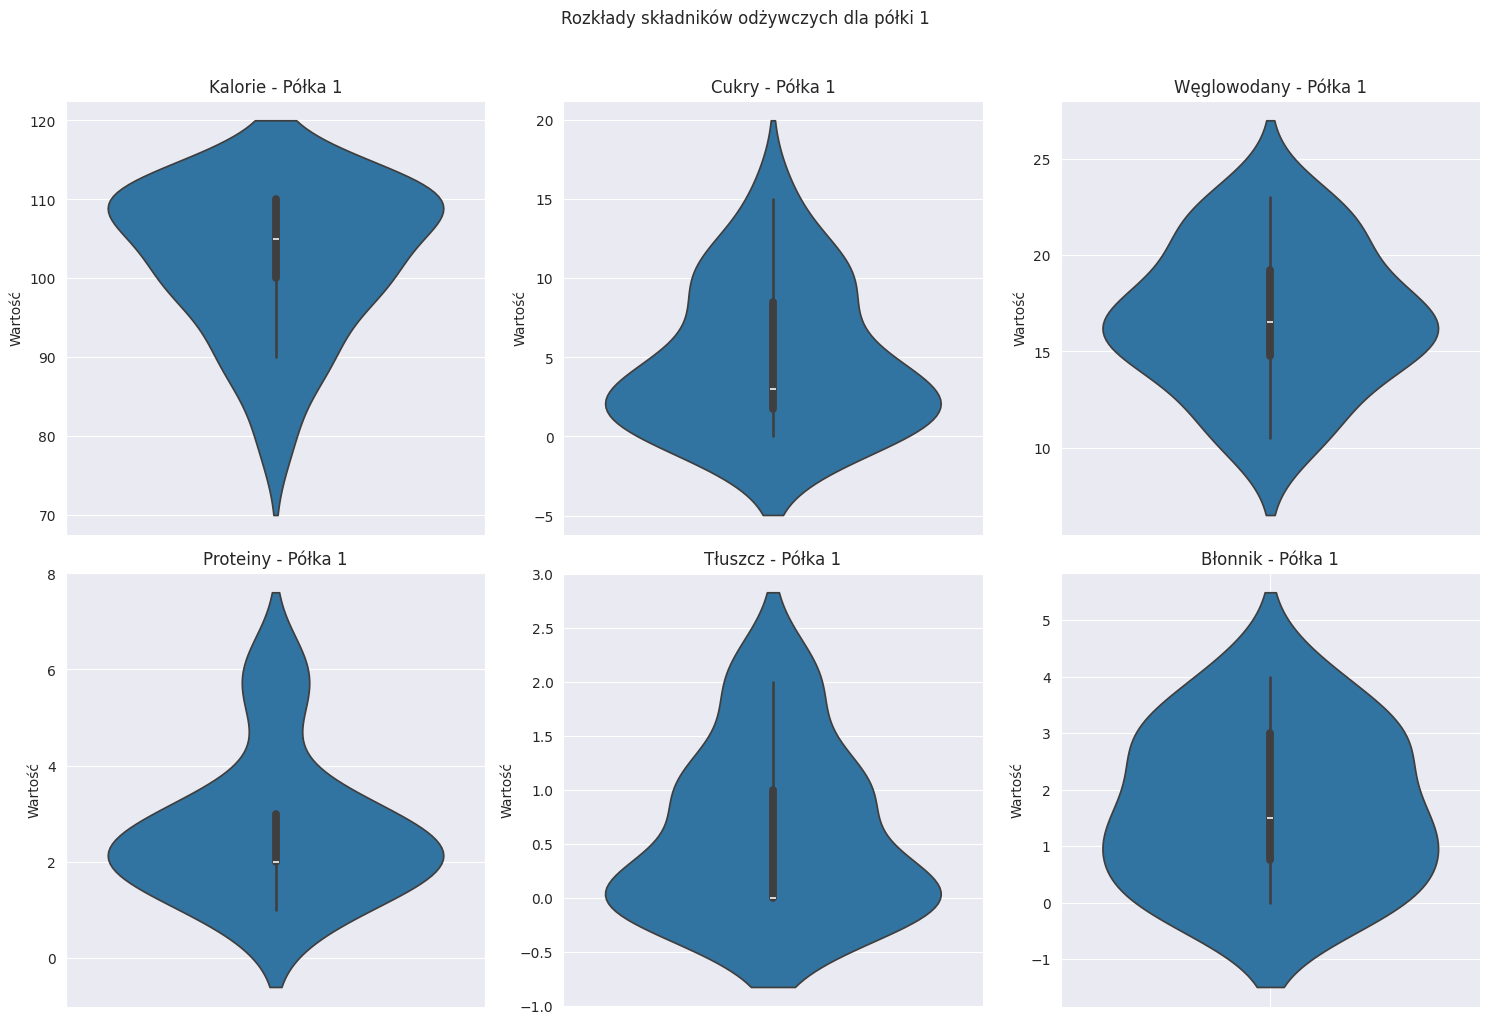

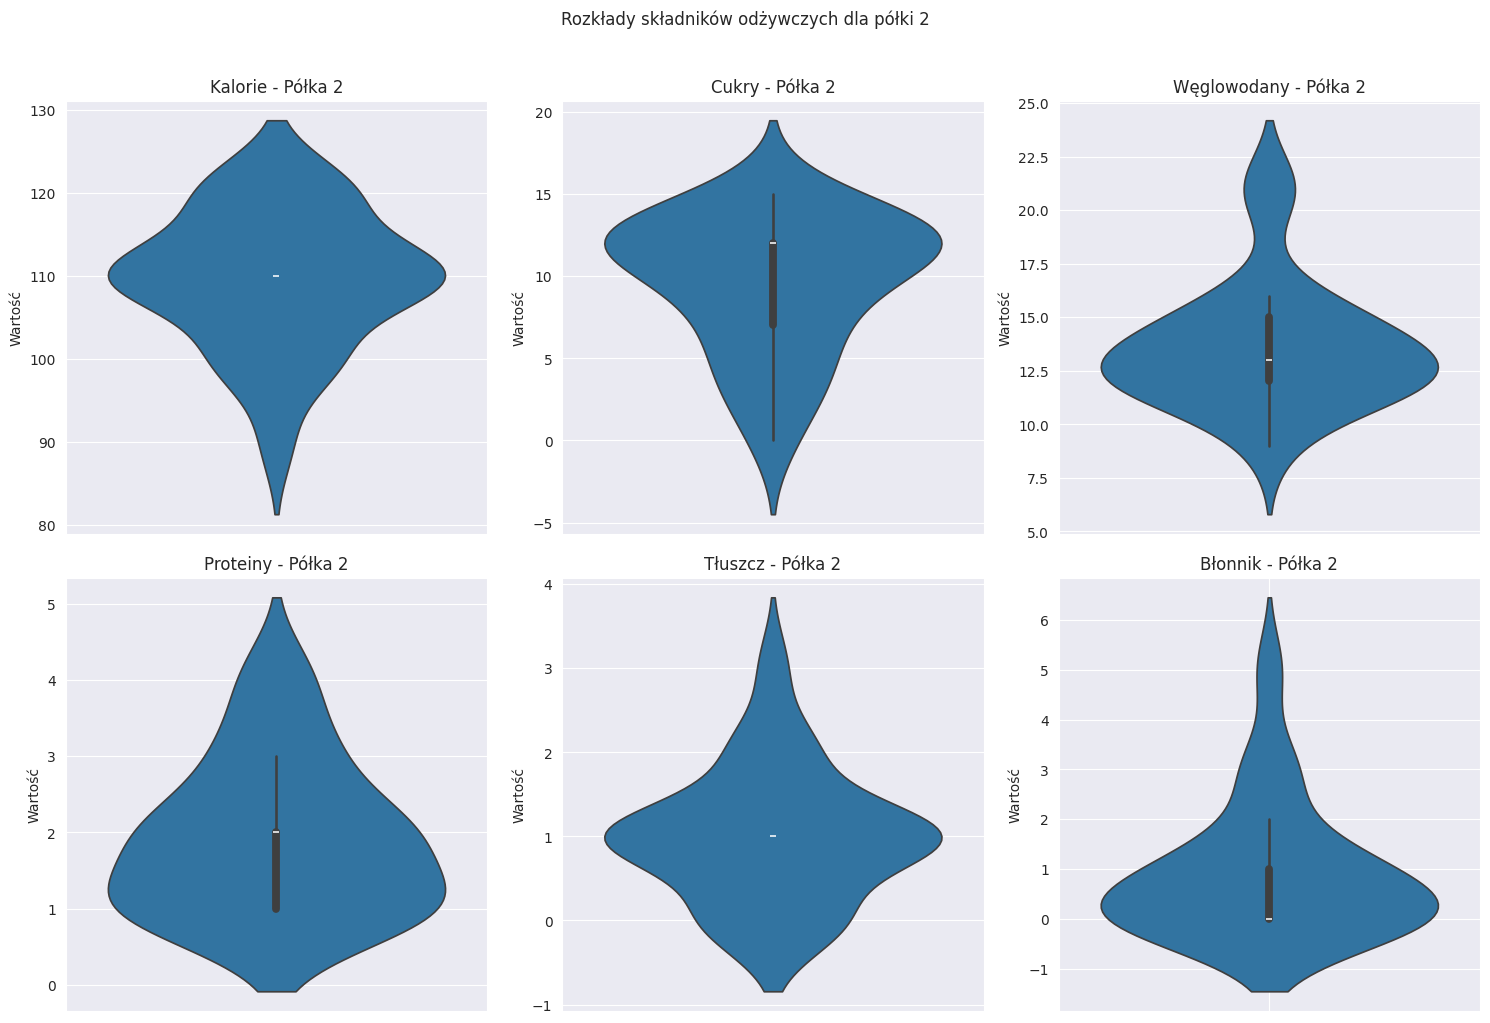

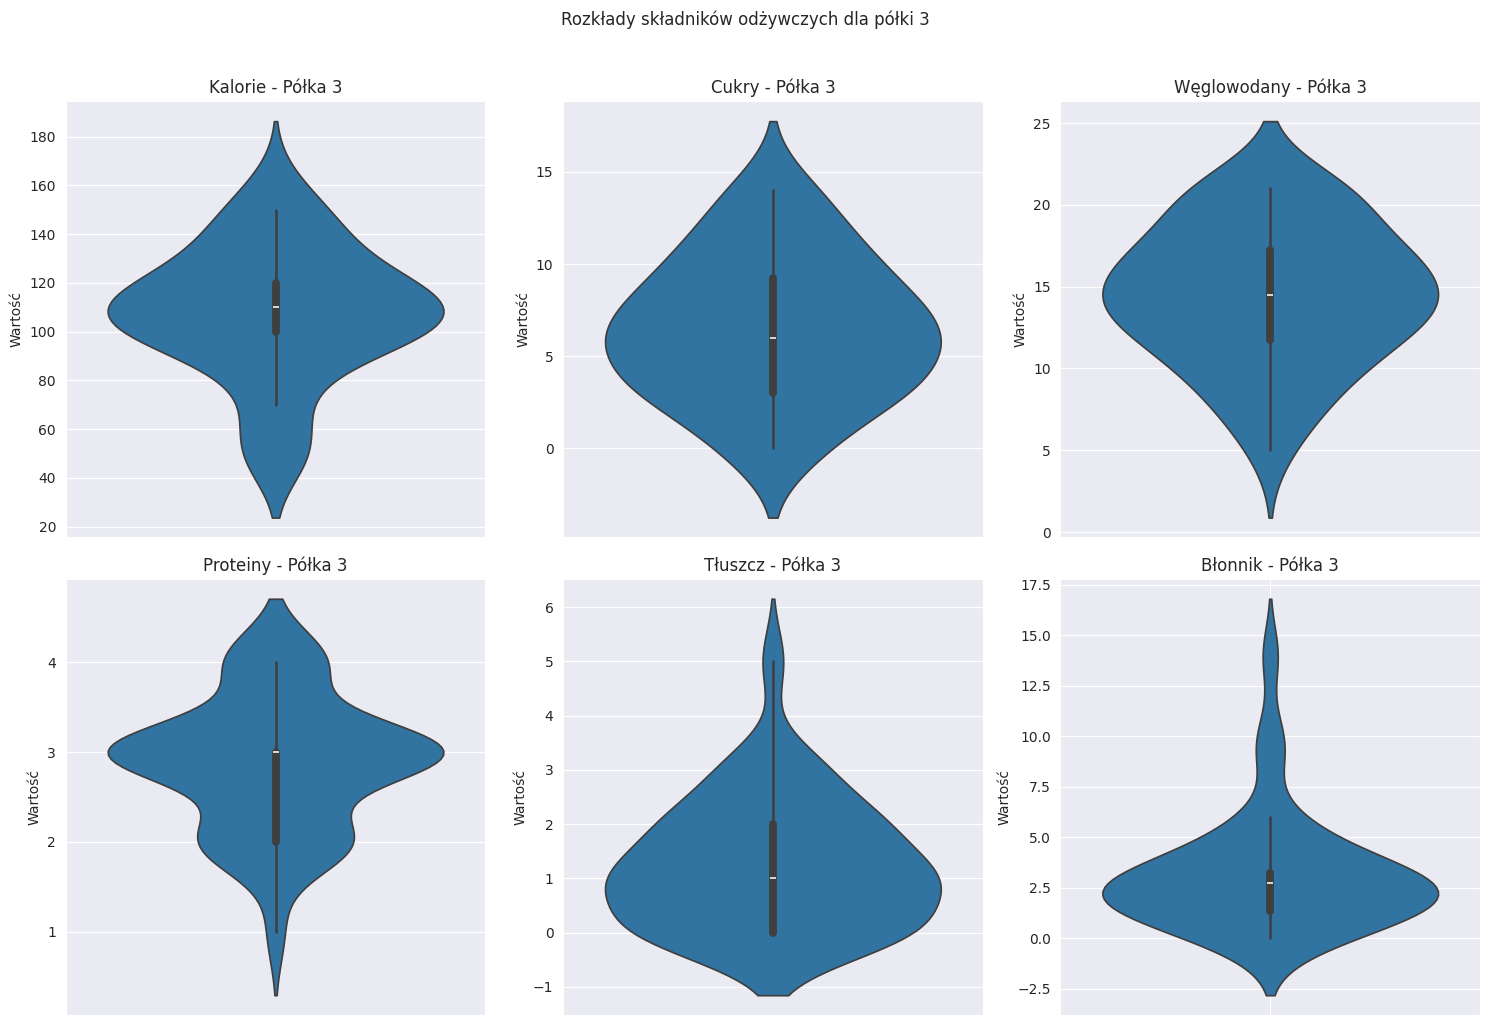

In [128]:
def create_detailed_violin_plots():
    # Tworzymy osobny wykres dla każdej półki
    for shelf in sorted(df['Liczba_polek'].unique()):
        shelf_data = df[df['Liczba_polek'] == shelf]

        plt.figure(figsize=(15, 10))
        for i, (nutrient, name) in enumerate(zip(nutrients, nutrient_names)):
            plt.subplot(2, 3, i + 1)
            sns.violinplot(y=nutrient, data=shelf_data, inner='box')
            plt.title(f'{name} - Półka {shelf}')
            plt.ylabel('Wartość')

        plt.suptitle(f'Rozkłady składników odżywczych dla półki {shelf}', y=1.02)
        plt.tight_layout()
        plt.grid(True)
        plt.show()


create_detailed_violin_plots()

### Wykresy radarowe dla profilu odżywczego kazdej półki



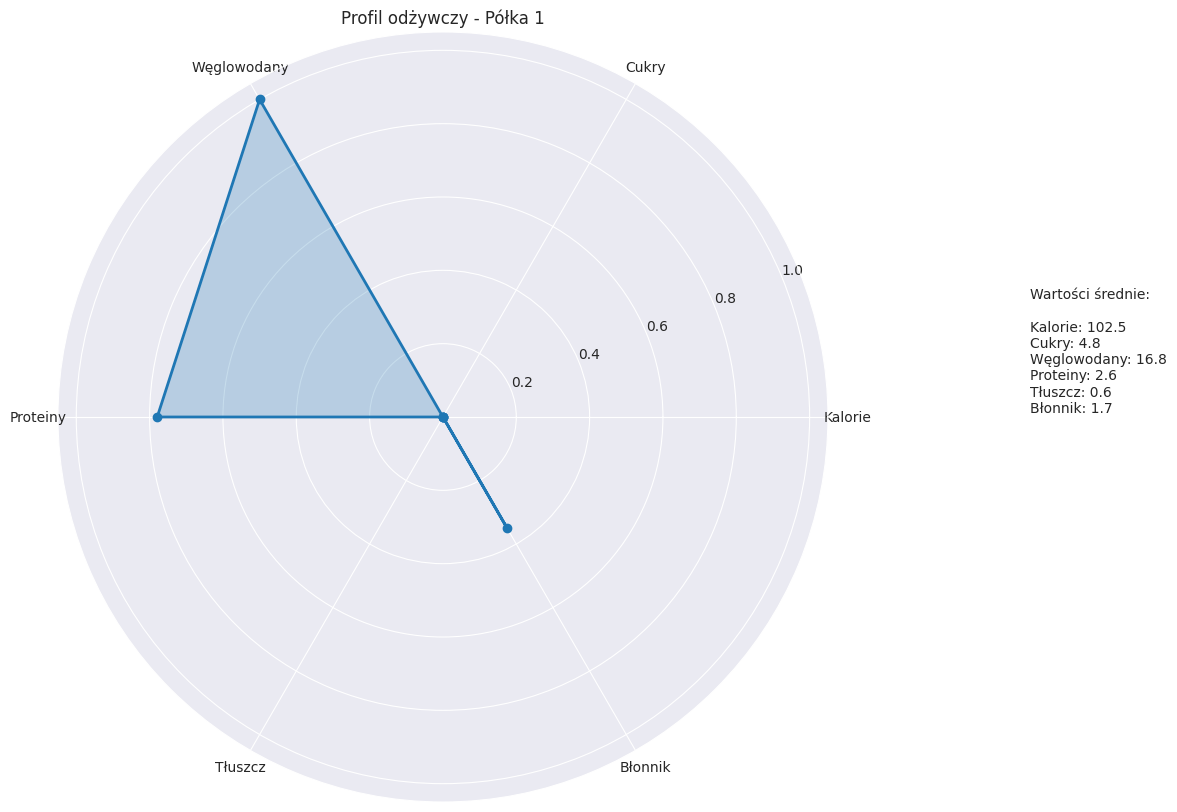

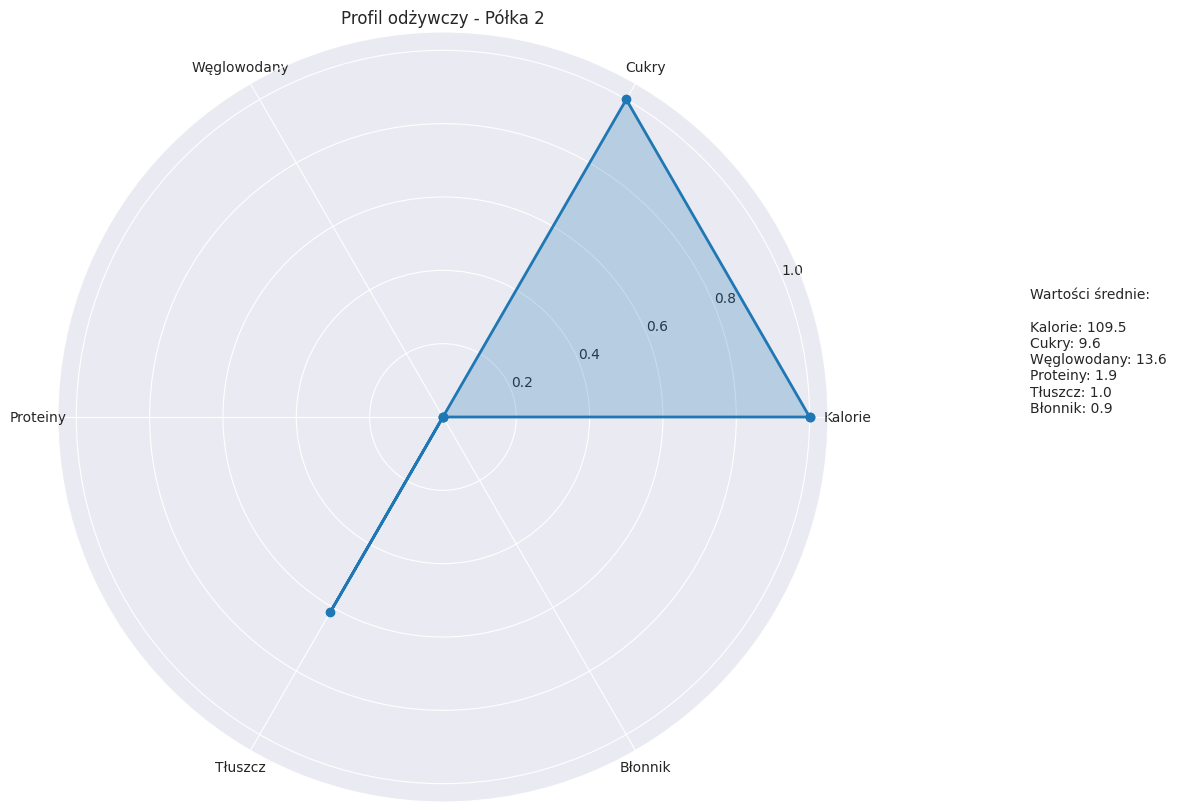

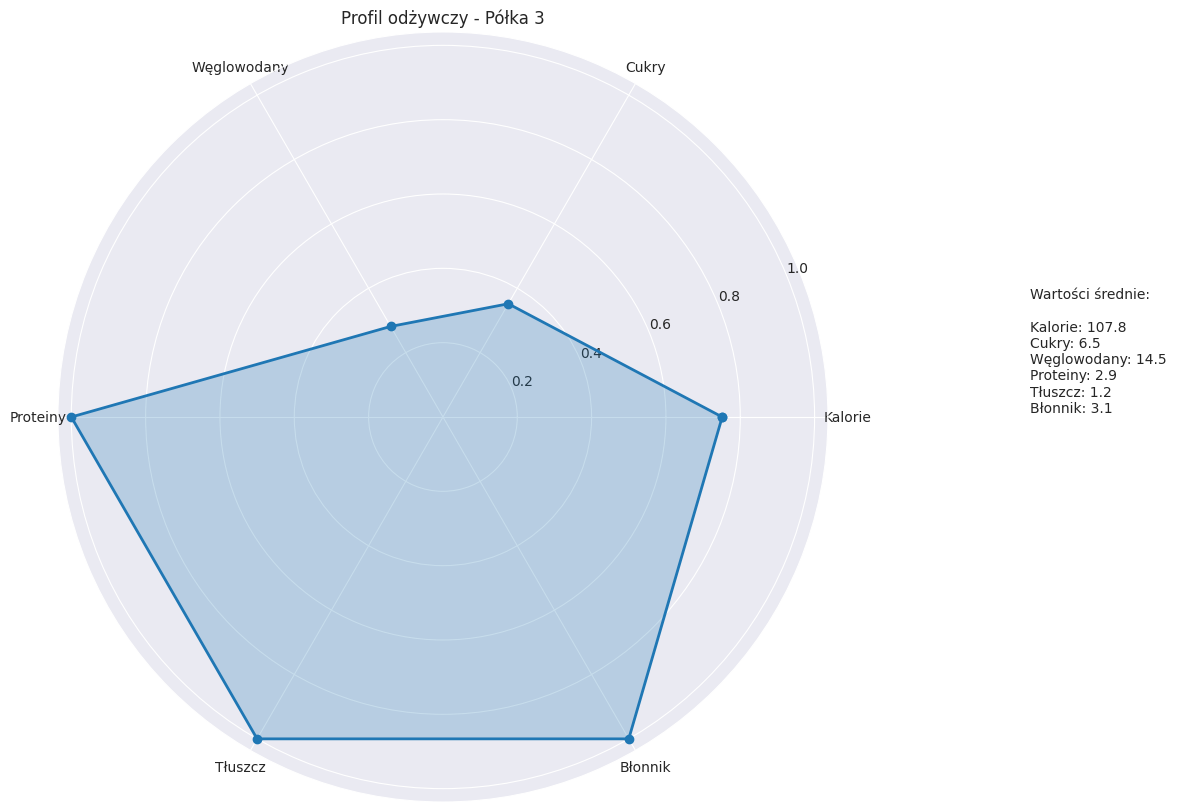

In [129]:
def create_radar_plots() -> None:
    # Tworzymy osobne wykresy dla każdej półki
    shelf_means = df.groupby('Liczba_polek')[nutrients].mean()

    # Normalizacja danych do 0,1 bo skala wartości jest różna
    shelf_means_norm = (shelf_means - shelf_means.min()) / (shelf_means.max() - shelf_means.min())

    # Linespace tworzy równo odległe wartości w zadanym przedziale
    angles = np.linspace(0, 2 * np.pi, len(nutrients), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Zamknięcie pętli

    for shelf in sorted(df['Liczba_polek'].unique()):
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

        values = shelf_means_norm.loc[shelf].values
        values = np.concatenate((values, [values[0]]))  # Konkatenacja ktora zamyka pętlę

        # Rysowanie wykresu
        ax.plot(angles, values, 'o-', linewidth=2, label=f'Półka {shelf}')
        ax.fill(angles, values, alpha=0.25)

        # Ustawienie nazw osi
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(nutrient_names)

        plt.title(f'Profil odżywczy - Półka {shelf}')

        # Dodanie oryginalnych wartości
        orig_values = shelf_means.loc[shelf].round(1)
        legend_text = '\n'.join([f'{name}: {value}'
                                 for name, value in zip(nutrient_names, orig_values)])
        plt.figtext(1.1, 0.5, f'Wartości średnie:\n\n{legend_text}',
                    bbox=dict(facecolor='white', alpha=0.8))

        plt.show()


create_radar_plots()

### Analiza skladu wedlug producenta - top 5


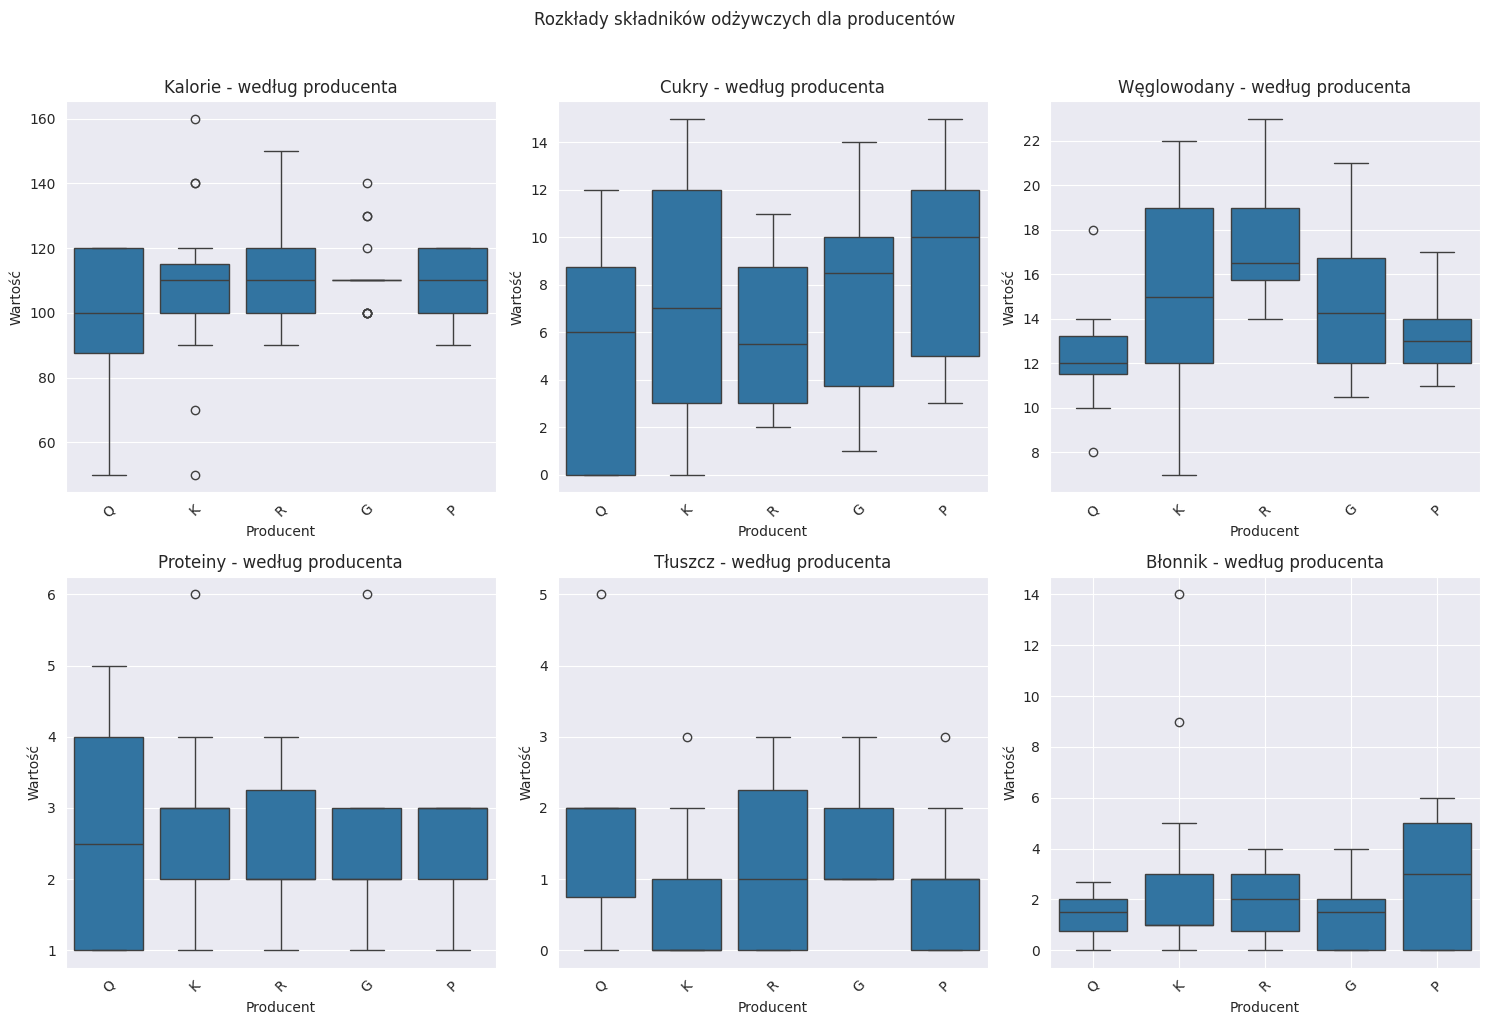

In [130]:
def analyze_by_manufacturer() -> None:
    # Grupowanie po producencie
    manufacturers = df['producent'].value_counts().head(5).index  # 5 najczęstszych producentów
    df_filtered = df[df['producent'].isin(manufacturers)]

    plt.figure(figsize=(15, 10))
    for i, (nutrient, name) in enumerate(zip(nutrients, nutrient_names)):
        plt.subplot(2, 3, i + 1)
        box_plot = sns.boxplot(x='producent', y=nutrient, data=df_filtered)
        plt.title(f'{name} - według producenta')
        plt.ylabel('Wartość')
        plt.xlabel('Producent')
        plt.xticks(rotation=45)

    plt.suptitle('Rozkłady składników odżywczych dla producentów', y=1.02)
    plt.tight_layout()
    plt.grid(True)
    plt.show()


analyze_by_manufacturer()

### Heatmapa srednich wartosci

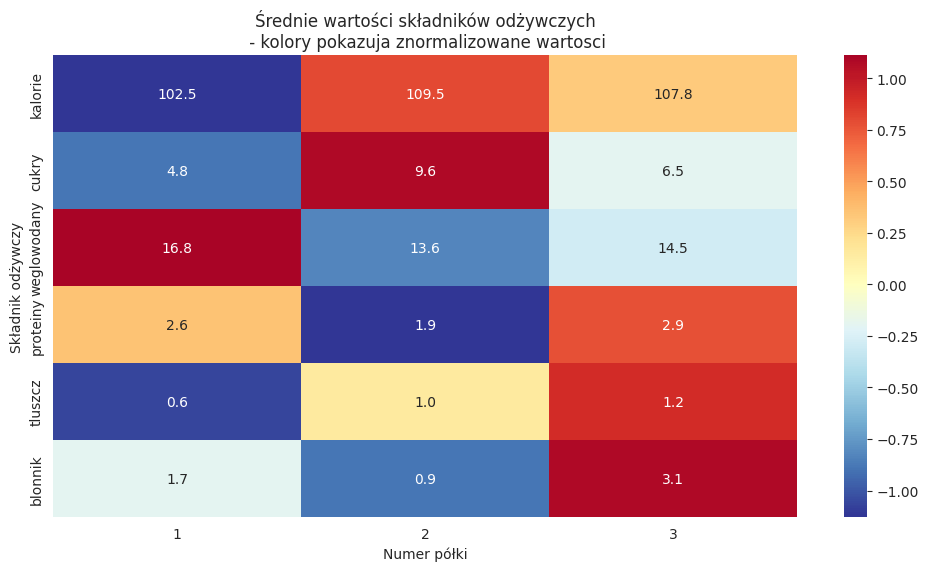

In [131]:
def create_nutrient_heatmap() -> None:
    shelf_means = df.groupby('Liczba_polek')[nutrients].mean()
    shelf_means_normalized = (shelf_means - shelf_means.mean()) / shelf_means.std()

    plt.figure(figsize=(12, 6))
    sns.heatmap(shelf_means_normalized.T,
                annot=shelf_means.T.round(1),
                fmt='.1f',
                cmap='RdYlBu_r',
                center=0)
    plt.title('Średnie wartości składników odżywczych\n - kolory pokazuja znormalizowane wartosci')
    plt.xlabel('Numer półki')
    plt.ylabel('Składnik odżywczy')
    plt.grid(True)
    plt.show()


create_nutrient_heatmap()

### Wykresy przedzialow srednich wartosci dla polek z 95% przedzialem ufności

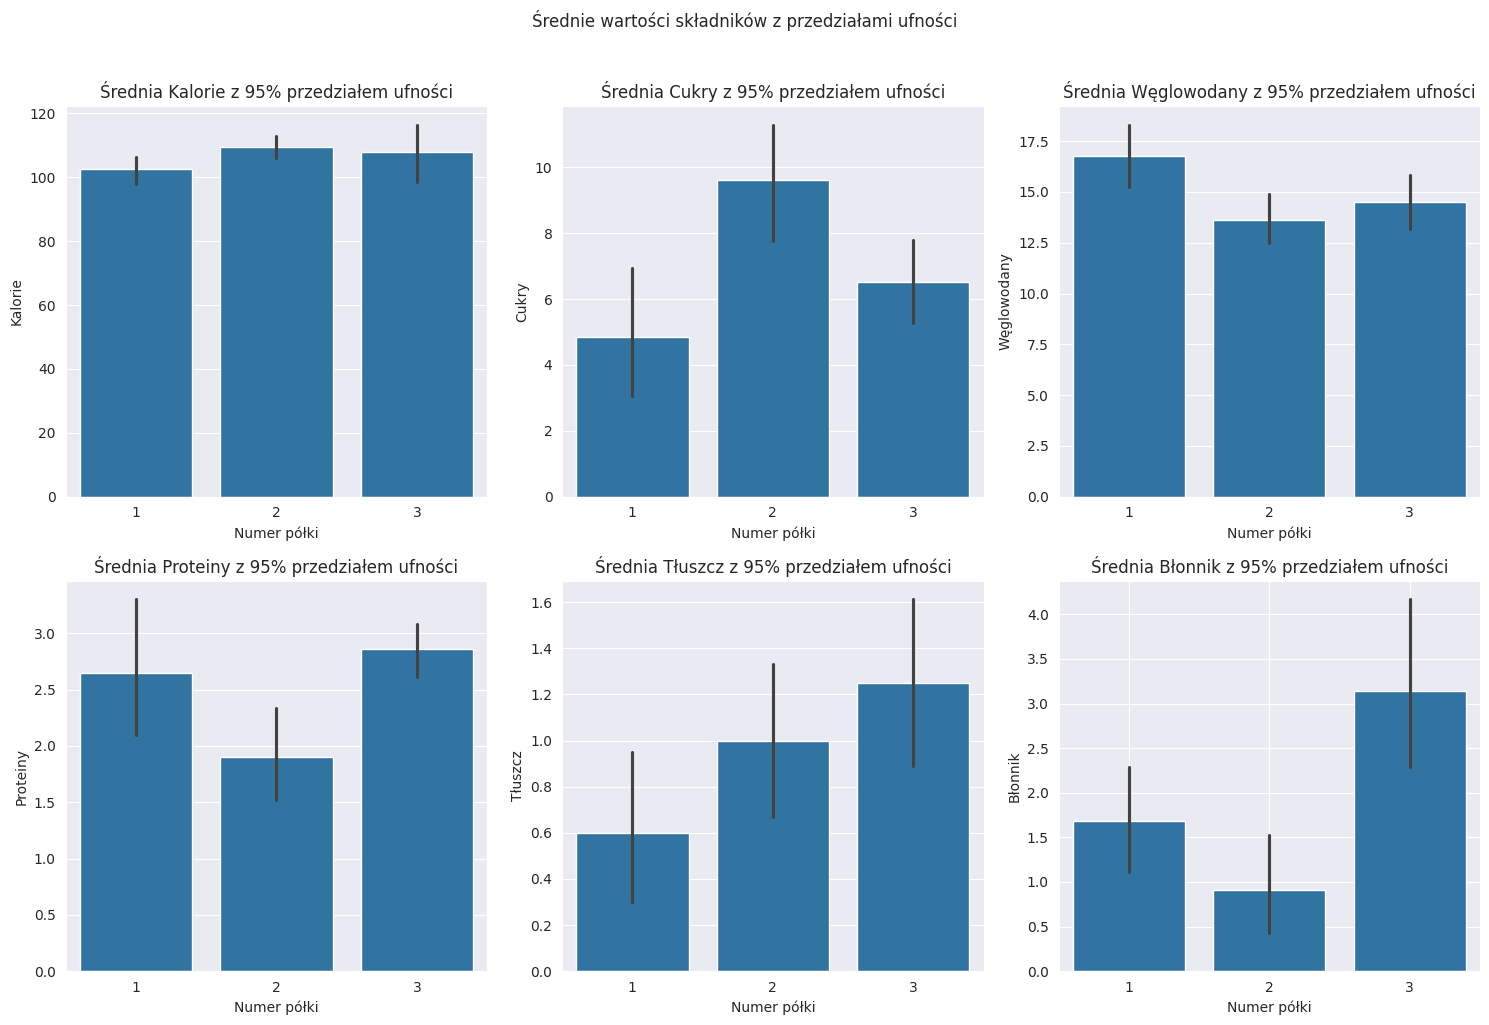

In [132]:
def plot_confidence_intervals() -> None:
    plt.figure(figsize=(15, 10))
    for i, (nutrient, name) in enumerate(zip(nutrients, nutrient_names)):
        plt.subplot(2, 3, i + 1)
        sns.barplot(x='Liczba_polek', y=nutrient, data=df, ci=95)
        plt.title(f'Średnia {name} z 95% przedziałem ufności')
        plt.xlabel('Numer półki')
        plt.ylabel(name)
    plt.suptitle('Średnie wartości składników z przedziałami ufności', y=1.02)
    plt.tight_layout()
    plt.grid(True)
    plt.show()


plot_confidence_intervals()

### Analiza korelacji miedzy potencjalnymi zmiennymi niezaleznymi

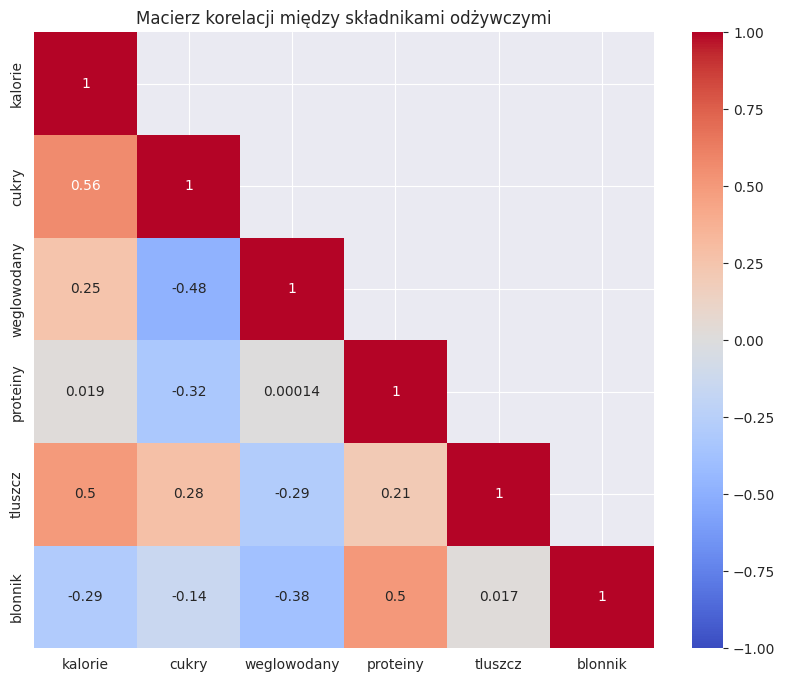

In [133]:
def plot_correlation_analysis() -> None:
    corr_matrix = df[nutrients].corr()  # Macierz korelacji

    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix), k=1)  # Maskowanie górnej trójkątnej macierzy
    sns.heatmap(corr_matrix,
                mask=mask,
                annot=True,
                cmap='coolwarm',
                vmin=-1,  # Skala korelacji od -1 do 1 
                vmax=1,
                center=0)
    plt.title('Macierz korelacji między składnikami odżywczymi')
    plt.show()


plot_correlation_analysis()

### Analiza statystyczna - testy statystyczne np. dla P-value

In [134]:
def detailed_statistical_analysis() -> None:
    print("\nSzczegółowa analiza statystyczna składników:")

    for nutrient, name in zip(nutrients, nutrient_names):
        print(f"\n{name}:")

        # Statystyki opisowe
        stats_by_shelf = (df.groupby('Liczba_polek')[nutrient]
                          .agg(['count', 'mean', 'std', 'min', 'max']))
        print("\nStatystyki według półek:")
        print(stats_by_shelf.round(2))

        # Test Kruskal-Wallis
        groups = [group for _, group in df.groupby('Liczba_polek')[nutrient]]
        h_stat, p_val = stats.kruskal(*groups)
        print(f"\nTest Kruskal-Wallis:")
        print(f"H-statistic = {h_stat:.2f}")
        print(f"p-value = {p_val:.4f}")


detailed_statistical_analysis()


Szczegółowa analiza statystyczna składników:

Kalorie:

Statystyki według półek:
              count    mean    std  min  max
Liczba_polek                                
1                20  102.50   9.10   80  110
2                21  109.52   8.05   90  120
3                36  107.78  26.95   50  160

Test Kruskal-Wallis:
H-statistic = 4.02
p-value = 0.1343

Cukry:

Statystyki według półek:
              count  mean   std  min  max
Liczba_polek                             
1                20  4.85  4.51    0   15
2                21  9.62  4.13    0   15
3                36  6.53  3.84    0   14

Test Kruskal-Wallis:
H-statistic = 13.01
p-value = 0.0015

Węglowodany:

Statystyki według półek:
              count   mean   std   min   max
Liczba_polek                                
1                20  16.75  3.64  10.5  23.0
2                21  13.62  2.94   9.0  21.0
3                36  14.50  4.21   5.0  21.0

Test Kruskal-Wallis:
H-statistic = 8.10
p-value = 0.0175

Proteiny

In [135]:
# Podsumowanie analiz
print("\nPodstawowe wnioski z analizy:")
for nutrient in nutrients:
    shelf_means = df.groupby('Liczba_polek')[nutrient].mean()  # Średnie wartości składników
    max_shelf = shelf_means.idxmax()
    min_shelf = shelf_means.idxmin()
    diff_percent = ((shelf_means[max_shelf] - shelf_means[min_shelf]) / shelf_means[min_shelf] * 100).round(2)

    print(f"\n{nutrient.capitalize()}:")
    print(f"- Różnica między półkami: {diff_percent:.1f}%")
    print(f"- Najwyższa średnia (półka {max_shelf}): {shelf_means[max_shelf]:.2f}")
    print(f"- Najniższa średnia (półka {min_shelf}): {shelf_means[min_shelf]:.2f}")


Podstawowe wnioski z analizy:

Kalorie:
- Różnica między półkami: 6.8%
- Najwyższa średnia (półka 2): 109.52
- Najniższa średnia (półka 1): 102.50

Cukry:
- Różnica między półkami: 98.3%
- Najwyższa średnia (półka 2): 9.62
- Najniższa średnia (półka 1): 4.85

Weglowodany:
- Różnica między półkami: 23.0%
- Najwyższa średnia (półka 1): 16.75
- Najniższa średnia (półka 2): 13.62

Proteiny:
- Różnica między półkami: 50.2%
- Najwyższa średnia (półka 3): 2.86
- Najniższa średnia (półka 2): 1.90

Tluszcz:
- Różnica między półkami: 108.3%
- Najwyższa średnia (półka 3): 1.25
- Najniższa średnia (półka 1): 0.60

Blonnik:
- Różnica między półkami: 246.9%
- Najwyższa średnia (półka 3): 3.14
- Najniższa średnia (półka 2): 0.90


## Klasyfikator dla polki srodkowej oraz dla wszystkich pol, metodami: 
#### - KNN
#### - Naive Bayes
#### - Random Forest

### Kalkulator metryki danego klasyfikatora - funckja pomocnicza

In [136]:
def calculate_metrics(conf_matrix: np.ndarray, model_name="") -> dict:
    """
    Oblicza i wyświetla wszystkie metryki dla danego klasyfikatora
    """

    # Wyciągnięcie wartości z macierzy
    TN, FP, FN, TP = conf_matrix.ravel()

    # Basic metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # precyzja
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # czułość
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # swoistość

    # F1 score mowi nam o zbalansowaniu pomiedzy precyzja i czułością
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Advanced metrics
    # Matthews Correlation Coefficient (MCC) mowi nam o zależności pomiedzy obserwowanymi i przewidywanymi wartościami
    mcc_numerator = (TP * TN) - (FP * FN)  # licznik współczynnika korelacji Matthews
    mcc_denominator = np.sqrt(
        (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))  # mianownik współczynnika korelacji Matthews
    mcc = mcc_numerator / mcc_denominator if mcc_denominator != 0 else 0

    balanced_accuracy = (recall + specificity) / 2  # zbalansowana dokładność
    informedness = recall + specificity - 1  # informacyjność
    markedness = precision + specificity - 1 if specificity > 0 else 0  # znakowność

    print(f"\n=== Metryki klasyfikacji {model_name} ===")
    print(f"Podstawowe metryki:")
    print(f"- Dokładność (Accuracy) = {accuracy:.3f}")
    print(f"- Precyzja (Precision) = {precision:.3f}")
    print(f"- Czułość (Recall/Sensitivity) = {recall:.3f}")
    print(f"- Swoistość (Specificity) = {specificity:.3f}")
    print(f"- F1 Score = {f1_score:.3f}")

    print(f"\nZaawansowane metryki:")
    print(f"- Matthews Correlation Coefficient (MCC) = {mcc:.3f}")
    print(f"- Balanced Accuracy = {balanced_accuracy:.3f}")
    print(f"- Informedness (Youden's J) = {informedness:.3f}")
    print(f"- Markedness = {markedness:.3f}")

    print(f"\nWartości macierzy pomyłek:")
    print(f"- True Negatives (TN) = {TN}")
    print(f"- False Positives (FP) = {FP}")
    print(f"- False Negatives (FN) = {FN}")
    print(f"- True Positives (TP) = {TP}")
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mcc': mcc,
        'balanced_accuracy': balanced_accuracy
    }


In [137]:
df = pd.read_csv('Płatki-sniadaniowe-cereals.txt', sep='\t')

print("=== Analiza danych wejściowych ===")
print(f"\nLiczba produktów: {len(df)}")
print("\nRozkład produktów na półkach:")
print(df[['polka_1', 'polka_2', 'polka_3']].sum())

=== Analiza danych wejściowych ===

Liczba produktów: 77

Rozkład produktów na półkach:
polka_1    20
polka_2    21
polka_3    36
dtype: int64


### Helper do trenowania i ewaluacji klasyfikatora

In [138]:
def train_and_evaluate_classifier(clf, X: np.ndarray, y: np.ndarray, classifier_name: str,
                                  is_simple_model=False):  # is_simple_model - model proponowany na podstawie wstepnej analizy danych
    """
    Trenuje i ewaluuje klasyfikator, zwraca metryki
    """
    try:
        # Cross-validation
        scores = cross_val_score(clf, X, y, cv=5)  # 5-krotna walidacja krzyżowa
        print(
            f"\nWyniki walidacji krzyżowej dla klasyfikatora {classifier_name}: {scores.mean():.3f} (±{scores.std():.3f})")

        clf.fit(X, y)  # Trenowanie klasyfikatora
        y_pred = clf.predict(X)  # Predykcja

        # Obliczanie metryk
        print(f"\n=== Wyniki klasyfikacji dla {classifier_name} ===")
        print(classification_report(y, y_pred))

        conf_matrix = confusion_matrix(y, y_pred)
        metrics = calculate_metrics(conf_matrix, classifier_name)

        if is_simple_model:
            # Wizualizacja macierzy pomyłek
            plt.figure(figsize=(10, 8))
            df_cm = pd.DataFrame(conf_matrix,
                                 index=['Nie na środkowej', 'Na środkowej'],
                                 columns=['Przewidziano: Nie', 'Przewidziano: Tak']
                                 )
            sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Macierz pomyłek dla klasyfikatora {classifier_name}')
            plt.ylabel('Prawdizwa wartość')
            plt.xlabel('Przewidywana wartość')
            plt.show()

        return clf, metrics  # Zwracamy klasyfikator i metryki

    except Exception as e:
        print(f"Wystąpił błąd podczas trenowania {classifier_name}: {str(e)}")
        return clf, None  # Zwracamy None w przypadku błędu

## Model 1: Klasyfikacja dla półki środkowej


=== Model 1: Klasyfikacja dla półki środkowej (cukier i kalorie) ===

=== Klasyfikator: Random Forest ===

Wyniki walidacji krzyżowej dla klasyfikatora Random Forest (Model 1 - środkowa półka): 0.805 (±0.116)

=== Wyniki klasyfikacji dla Random Forest (Model 1 - środkowa półka) ===
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        56
           1       0.94      0.76      0.84        21

    accuracy                           0.92        77
   macro avg       0.93      0.87      0.90        77
weighted avg       0.92      0.92      0.92        77


=== Metryki klasyfikacji Random Forest (Model 1 - środkowa półka) ===
Podstawowe metryki:
- Dokładność (Accuracy) = 0.922
- Precyzja (Precision) = 0.941
- Czułość (Recall/Sensitivity) = 0.762
- Swoistość (Specificity) = 0.982
- F1 Score = 0.842

Zaawansowane metryki:
- Matthews Correlation Coefficient (MCC) = 0.799
- Balanced Accuracy = 0.872
- Informedness (Youden's J) = 0.744
- Marke

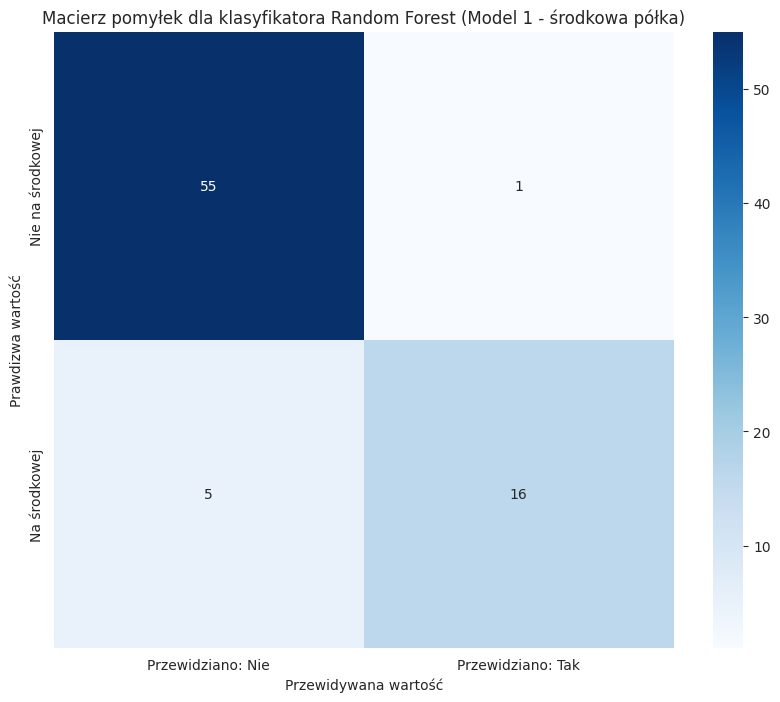


=== Klasyfikator: KNN ===

Wyniki walidacji krzyżowej dla klasyfikatora KNN (Model 1 - środkowa półka): 0.818 (±0.083)

=== Wyniki klasyfikacji dla KNN (Model 1 - środkowa półka) ===
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        56
           1       0.78      0.67      0.72        21

    accuracy                           0.86        77
   macro avg       0.83      0.80      0.81        77
weighted avg       0.85      0.86      0.85        77


=== Metryki klasyfikacji KNN (Model 1 - środkowa półka) ===
Podstawowe metryki:
- Dokładność (Accuracy) = 0.857
- Precyzja (Precision) = 0.778
- Czułość (Recall/Sensitivity) = 0.667
- Swoistość (Specificity) = 0.929
- F1 Score = 0.718

Zaawansowane metryki:
- Matthews Correlation Coefficient (MCC) = 0.626
- Balanced Accuracy = 0.798
- Informedness (Youden's J) = 0.595
- Markedness = 0.706

Wartości macierzy pomyłek:
- True Negatives (TN) = 52
- False Positives (FP) = 4
- False Negati

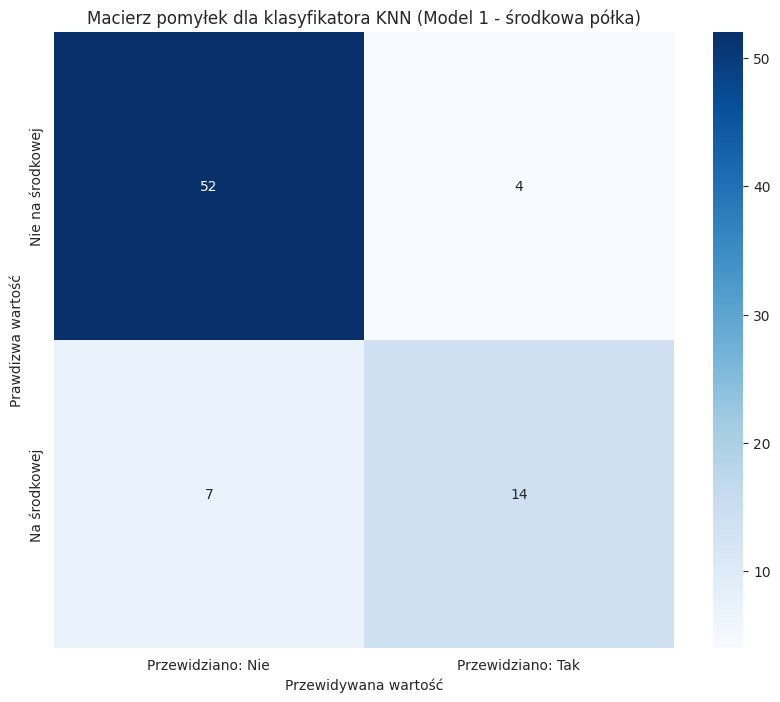


=== Klasyfikator: Naive Bayes ===

Wyniki walidacji krzyżowej dla klasyfikatora Naive Bayes (Model 1 - środkowa półka): 0.755 (±0.080)

=== Wyniki klasyfikacji dla Naive Bayes (Model 1 - środkowa półka) ===
              precision    recall  f1-score   support

           0       0.85      0.84      0.85        56
           1       0.59      0.62      0.60        21

    accuracy                           0.78        77
   macro avg       0.72      0.73      0.73        77
weighted avg       0.78      0.78      0.78        77


=== Metryki klasyfikacji Naive Bayes (Model 1 - środkowa półka) ===
Podstawowe metryki:
- Dokładność (Accuracy) = 0.779
- Precyzja (Precision) = 0.591
- Czułość (Recall/Sensitivity) = 0.619
- Swoistość (Specificity) = 0.839
- F1 Score = 0.605

Zaawansowane metryki:
- Matthews Correlation Coefficient (MCC) = 0.452
- Balanced Accuracy = 0.729
- Informedness (Youden's J) = 0.458
- Markedness = 0.430

Wartości macierzy pomyłek:
- True Negatives (TN) = 47
- False P

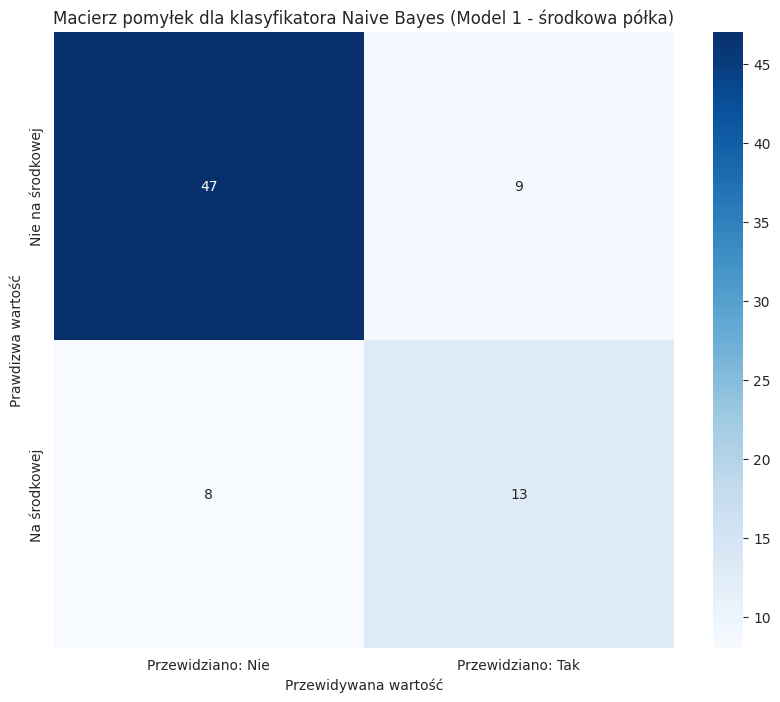

In [139]:
print("\n=== Model 1: Klasyfikacja dla półki środkowej (cukier i kalorie) ===")
X_simple = df[['cukry', 'kalorie']]
y_middle = (df['polka_2'] == 1).astype(int)  # Klasyfikacja dla półki środkowej

# Standaryzacja danych 
scaler_simple = StandardScaler()
scaler_simple.fit(X_simple)
X_simple_scaled = scaler_simple.transform(X_simple)

# Inicjalizacja klasyfikatorów
classifiers_simple = {
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

# Trenowanie i ewaulacja klasyfikatora dla prostego modelu
results_simple = {}
for name, clf in classifiers_simple.items():
    print(f"\n=== Klasyfikator: {name} ===")
    trained_clf, metrics = train_and_evaluate_classifier(clf,
                                                         X_simple_scaled,
                                                         y_middle,
                                                         f"{name} (Model 1 - środkowa półka)",
                                                         is_simple_model=True
                                                         )
    results_simple[name] = metrics


### Wizualizacja porównawcza dla prostego modelu (środkowa półka). Prosty model czyli ten gdzie to MY wybieramy zmienne niezalezne 

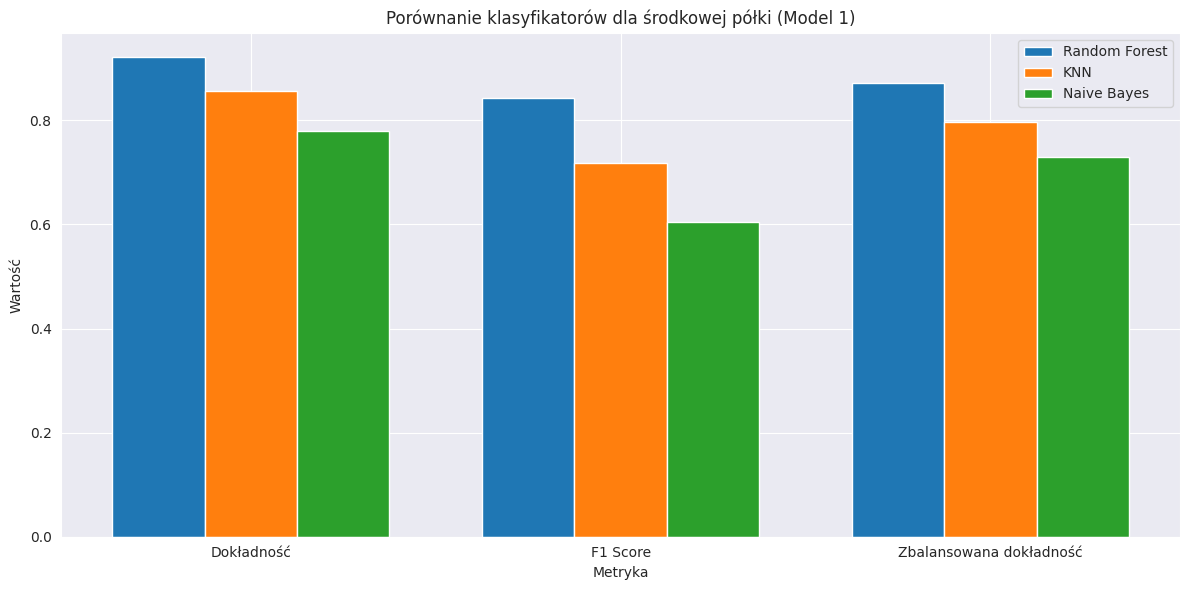

In [140]:
# Wizualizacja porównawcza dla prostego modelu (środkowa półka)
metrics_to_plot = ['accuracy', 'f1_score', 'balanced_accuracy']
metrics_labels = ['Dokładność', 'F1 Score', 'Zbalansowana dokładność']

plt.figure(figsize=(12, 6))
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (clf_name, metrics) in enumerate(results_simple.items()):
    values = [metrics[metric] for metric in metrics_to_plot]
    plt.bar(x + i * width, values, width, label=clf_name)

plt.xlabel('Metryka')
plt.ylabel('Wartość')
plt.title('Porównanie klasyfikatorów dla środkowej półki (Model 1)')
plt.xticks(x + width, metrics_labels)
plt.legend()
plt.tight_layout()
plt.show()

## Model 2: Klasyfikacja dla wszystkich polek i wybor optymalny cech

In [141]:
print("\n=== Model 2: Klasyfikacja dla poszczególnych półek ===")
features = ['kalorie', 'cukry', 'weglowodany', 'proteiny', 'tluszcz', 'blonnik', 'sod', 'potas']
X_full = df[features]
scaler_full = StandardScaler()
scaler_full.fit(X_full)
X_full_scaled = scaler_full.transform(X_full)  # Standaryzacja danych

# Inicjalizacja klasyfikatorów
results_full = {'polka_1': {}, 'polka_2': {}, 'polka_3': {}}

# Analiza kazdej polki z osobna
for shelf_num, shelf in enumerate(['polka_1', 'polka_2', 'polka_3'], 1):
    print(f"\n=== Analiza półki {shelf_num} ===")
    y_shelf = (df[shelf] == 1).astype(int)  # Klasyfikacja dla danej półki

    # Wybor cech za pomoca Random Forest
    selector = SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=42))
    selector.fit(X_full_scaled, y_shelf)  # Trenowanie modelu
    selected_mask = selector.get_support()  # Wybor cech 

    # Wyswietlenie wybranych cech
    selected_features = [feat for feat, selected in zip(features, selected_mask) if selected]
    # tlumaczenie tego fora to: dla kazdego elementu w features i selected_mask jesli selected to dodaj do listy
    print(f"Wybrane cechy dla półki {shelf_num}: {selected_features}")

    # Trenowanie i ewaluacja klasyfikatora 
    X_selected = X_full_scaled[:, selected_mask]  # Wybranie cech
    for name in classifiers_simple.keys():
        if name == 'Random Forest':
            clf = RandomForestClassifier(n_estimators=200, random_state=42)
        elif name == 'k-NN':
            clf = KNeighborsClassifier(n_neighbors=5)
        else:  # Naive Bayes
            clf = GaussianNB()

        print(f"\n=== Klasyfikator: {name} ===")
        trained_clf, metrics = train_and_evaluate_classifier(
            clf,
            X_selected,
            y_shelf,
            f"{name} (Model 2 - półka {shelf_num})"
        )
        if metrics is not None:  # Dodajemy sprawdzenie
            results_full[shelf][name] = metrics
        else:
            print(f"Pominięto wyniki dla {name} na półce {shelf_num} z powodu błędu")


=== Model 2: Klasyfikacja dla poszczególnych półek ===

=== Analiza półki 1 ===
Wybrane cechy dla półki 1: ['cukry', 'weglowodany', 'sod', 'potas']

=== Klasyfikator: Random Forest ===

Wyniki walidacji krzyżowej dla klasyfikatora Random Forest (Model 2 - półka 1): 0.806 (±0.070)

=== Wyniki klasyfikacji dla Random Forest (Model 2 - półka 1) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        20

    accuracy                           1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77


=== Metryki klasyfikacji Random Forest (Model 2 - półka 1) ===
Podstawowe metryki:
- Dokładność (Accuracy) = 1.000
- Precyzja (Precision) = 1.000
- Czułość (Recall/Sensitivity) = 1.000
- Swoistość (Specificity) = 1.000
- F1 Score = 1.000

Zaawansowane metryki:
- Matthews Correlation Coefficient (MCC) = 1.000
- Balanced Ac

### Wizualizacja porównawcza dla wszystkich półek (Model 2)

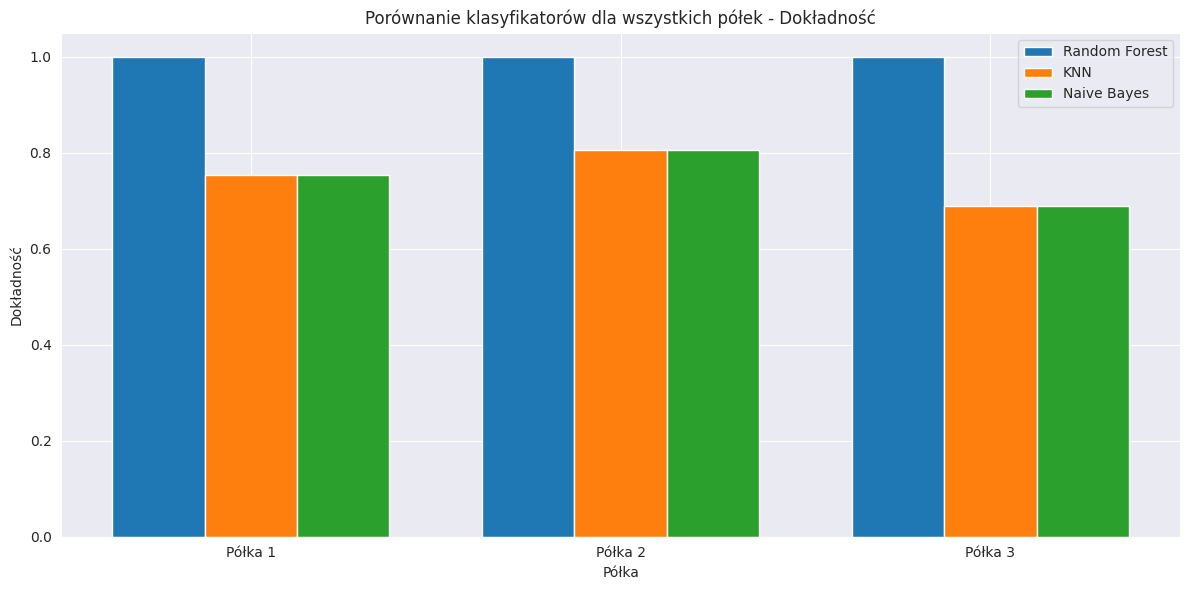

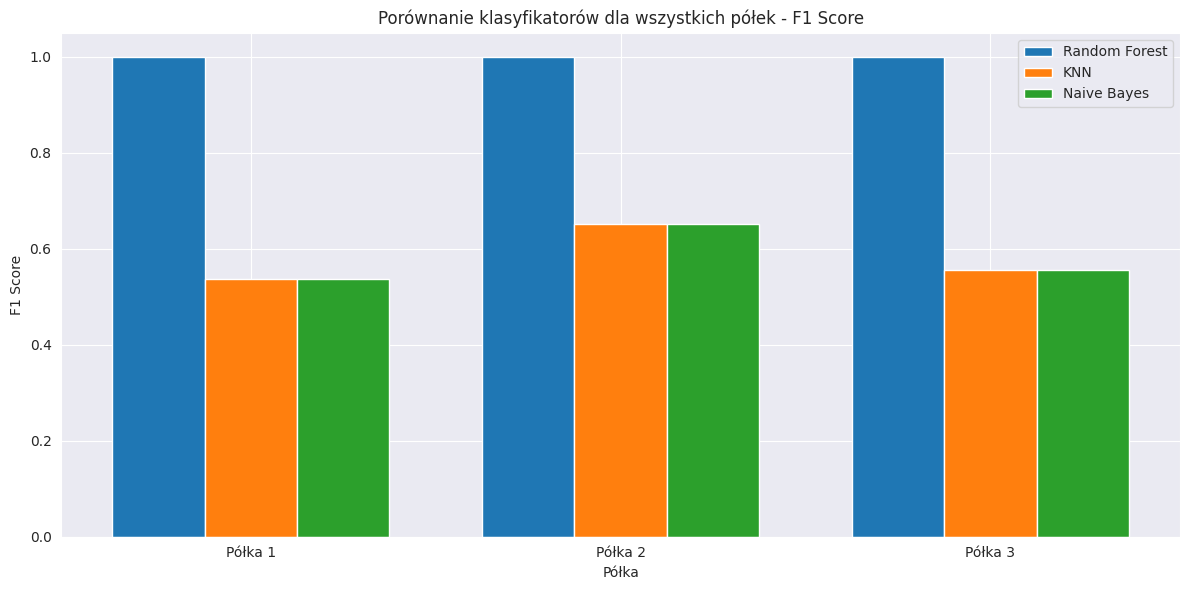

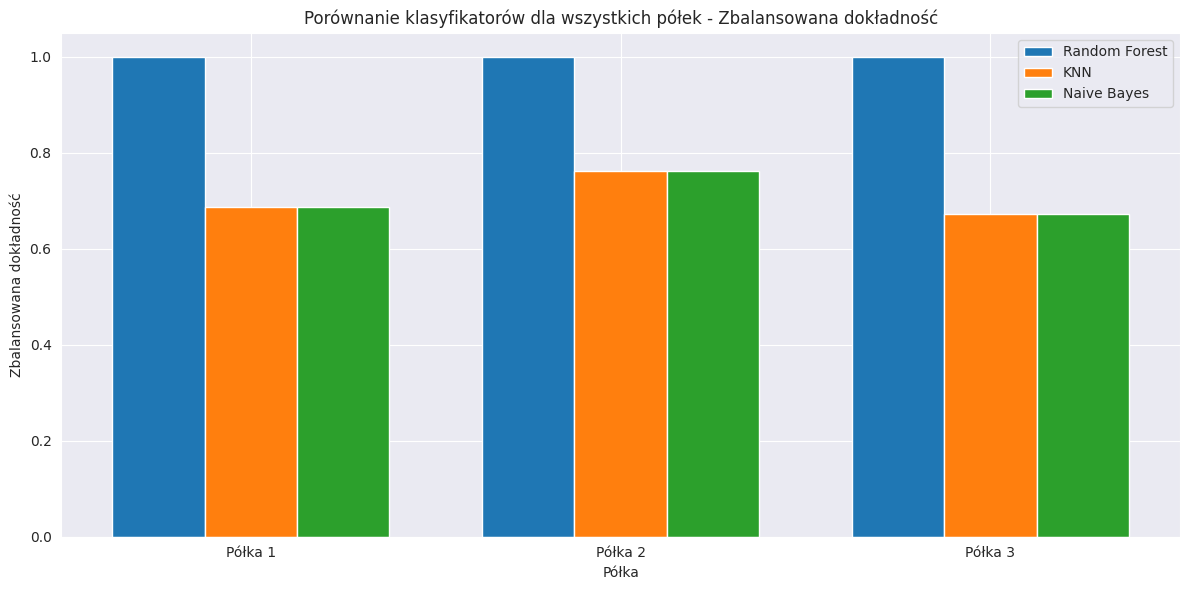

In [142]:
# Wizualizacja porównawcza dla wszystkich półek (Model 2)
for metric in metrics_to_plot:
    plt.figure(figsize=(12, 6))
    x = np.arange(len(results_full))
    width = 0.25
    
    for i, clf_name in enumerate(classifiers_simple.keys()):
        values = [results_full[shelf][clf_name][metric] for shelf in results_full]
        plt.bar(x + i * width, values, width, label=clf_name)
    
    plt.xlabel('Półka')
    plt.ylabel(f'{metrics_labels[metrics_to_plot.index(metric)]}')
    plt.title(f'Porównanie klasyfikatorów dla wszystkich półek - {metrics_labels[metrics_to_plot.index(metric)]}')
    plt.xticks(x + width, ['Półka 1', 'Półka 2', 'Półka 3'])
    plt.legend()
    plt.tight_layout()
    plt.show()

### Podsumowanie wynikow tekstowe

In [143]:
# Podsumowanie wyników
print("\n=== Podsumowanie wyników ===")

print("\n++ Model 1 (Środkowa półka): ++")
for clf_name, metrics in results_simple.items():
    print(f"\n{clf_name}:")
    for metric, value in metrics.items():
        print(f"- {metric}: {value:.3f}")

print("\n++ Model 2 (Wszystkie półki): ++")
for shelf in results_full:
    print(f"\nPółka {shelf}:")
    for clf_name, metrics in results_full[shelf].items():
        print(f"\n{clf_name}:")
        for metric, value in metrics.items():
            print(f"- {metric}: {value:.3f}")


=== Podsumowanie wyników ===

++ Model 1 (Środkowa półka): ++

Random Forest:
- accuracy: 0.922
- precision: 0.941
- recall: 0.762
- f1_score: 0.842
- mcc: 0.799
- balanced_accuracy: 0.872

KNN:
- accuracy: 0.857
- precision: 0.778
- recall: 0.667
- f1_score: 0.718
- mcc: 0.626
- balanced_accuracy: 0.798

Naive Bayes:
- accuracy: 0.779
- precision: 0.591
- recall: 0.619
- f1_score: 0.605
- mcc: 0.452
- balanced_accuracy: 0.729

++ Model 2 (Wszystkie półki): ++

Półka polka_1:

Random Forest:
- accuracy: 1.000
- precision: 1.000
- recall: 1.000
- f1_score: 1.000
- mcc: 1.000
- balanced_accuracy: 1.000

KNN:
- accuracy: 0.753
- precision: 0.524
- recall: 0.550
- f1_score: 0.537
- mcc: 0.369
- balanced_accuracy: 0.687

Naive Bayes:
- accuracy: 0.753
- precision: 0.524
- recall: 0.550
- f1_score: 0.537
- mcc: 0.369
- balanced_accuracy: 0.687

Półka polka_2:

Random Forest:
- accuracy: 1.000
- precision: 1.000
- recall: 1.000
- f1_score: 1.000
- mcc: 1.000
- balanced_accuracy: 1.000

KNN:


### Wizualizacja macierzy pomyłek dla wszystkich klasyfikatorów

=== Macierze pomyłek dla wszystkich klasyfikatorów ===


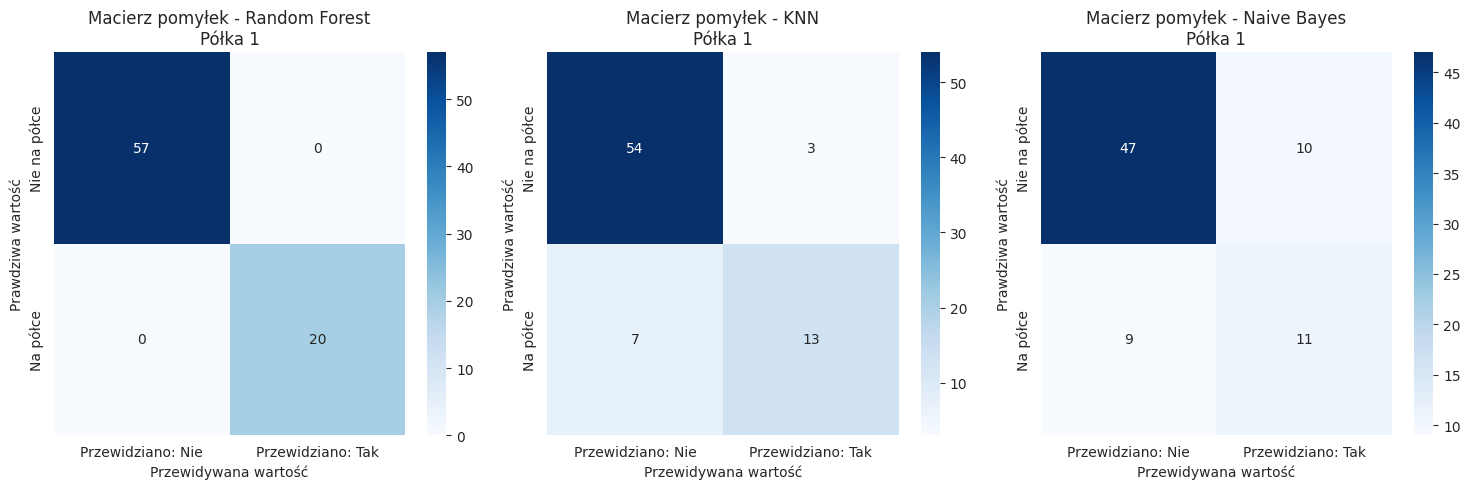

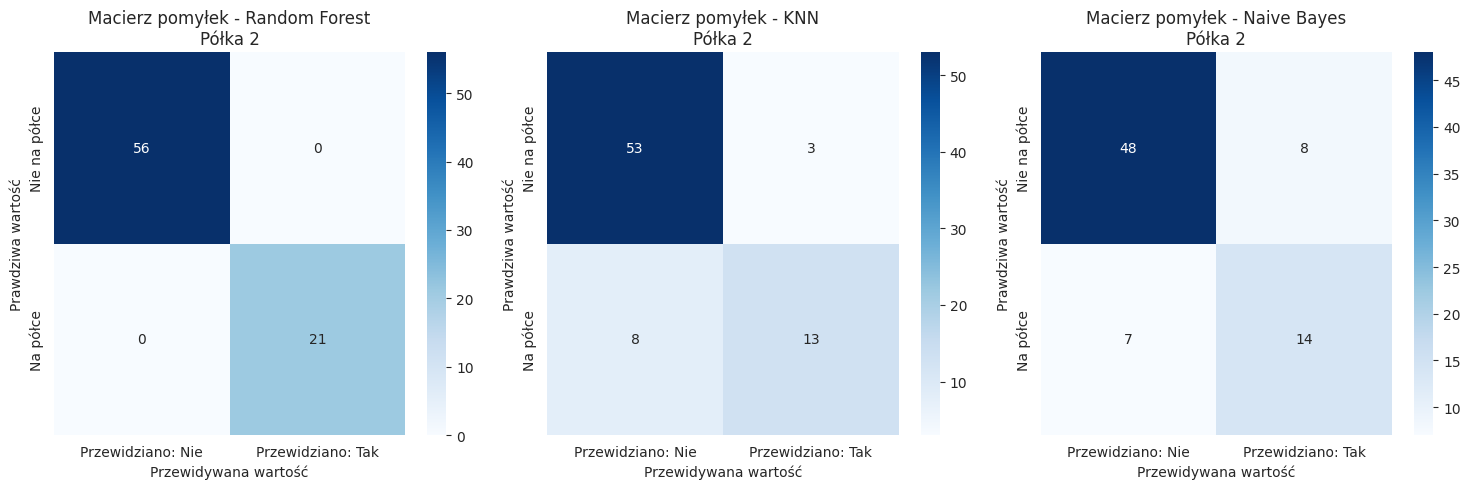

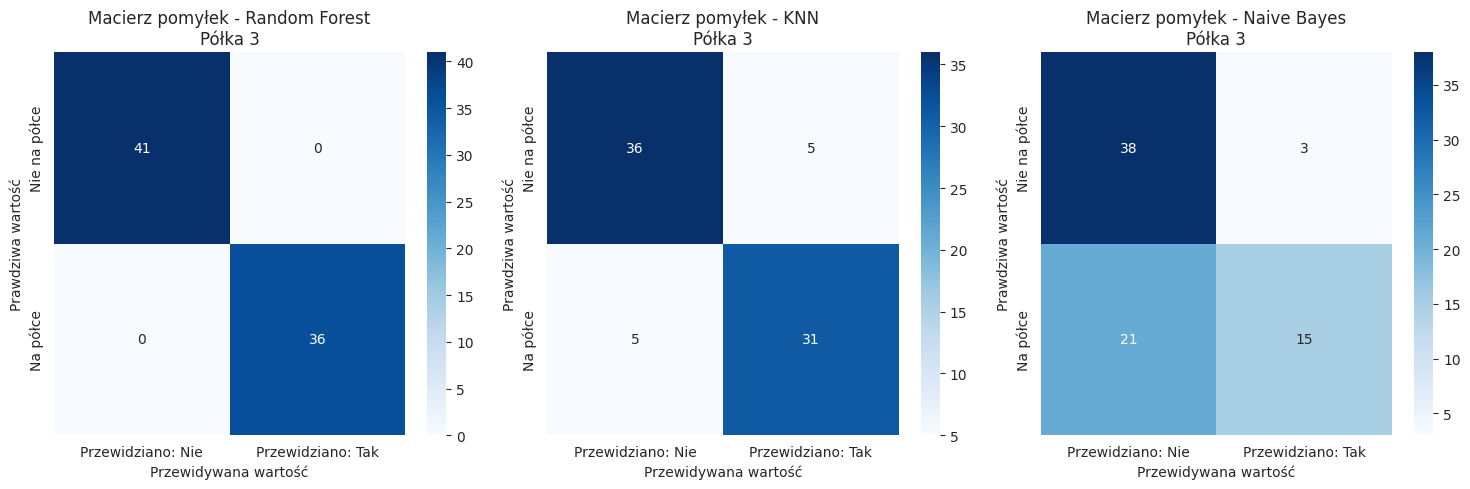

In [144]:
# Wizualizacja macierzy pomyłek dla wszystkich klasyfikatorów
def plot_confusion_matrices():
    for shelf_num, shelf in enumerate(['polka_1', 'polka_2', 'polka_3'], 1):
        plt.figure(figsize=(15, 5))
        for i, (clf_name, metrics) in enumerate(results_full[shelf].items(), 1):
            y_shelf = (df[shelf] == 1).astype(int)
            
            if clf_name == 'Random Forest':
                clf = RandomForestClassifier(n_estimators=200, random_state=42)
            elif clf_name == 'KNN':
                clf = KNeighborsClassifier(n_neighbors=5)
            else:  # Naive Bayes
                clf = GaussianNB()
            
            # Wybór cech
            selector = SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=42))
            selector.fit(X_full_scaled, y_shelf)
            selected_mask = selector.get_support()
            X_selected = X_full_scaled[:, selected_mask]
            
            # Trenowanie i predykcja
            clf.fit(X_selected, y_shelf)
            y_pred = clf.predict(X_selected)
            conf_matrix = confusion_matrix(y_shelf, y_pred)
            
            # Wizualizacja macierzy pomyłek
            plt.subplot(1, 3, i)
            df_cm = pd.DataFrame(
                conf_matrix,
                index=['Nie na półce', 'Na półce'],
                columns=['Przewidziano: Nie', 'Przewidziano: Tak']
            )
            sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Macierz pomyłek - {clf_name}\nPółka {shelf_num}')
            plt.ylabel('Prawdziwa wartość')
            plt.xlabel('Przewidywana wartość')
        
        plt.tight_layout()
        plt.show()

# Generowanie wszystkich wizualizacji
print("=== Macierze pomyłek dla wszystkich klasyfikatorów ===")
plot_confusion_matrices()

### Wizualizacja wag zmiennych


=== Ważność cech dla każdej półki ===


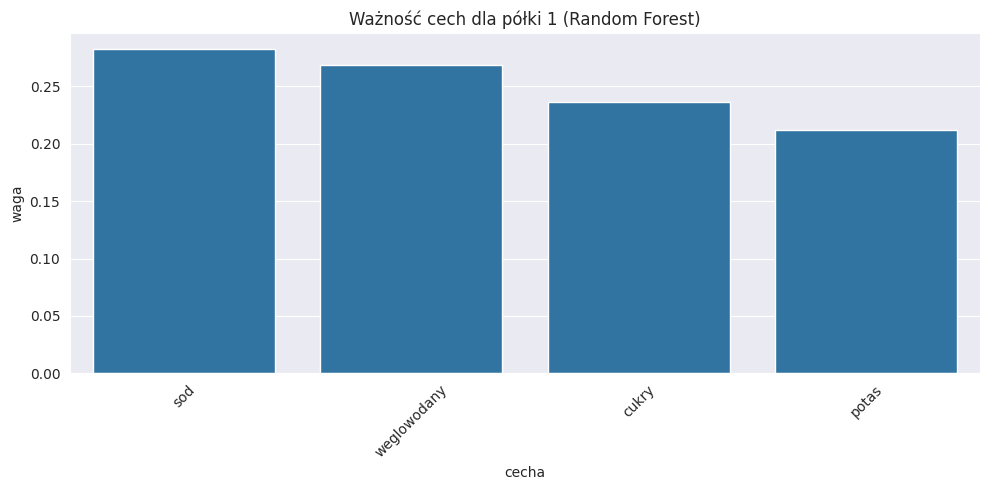

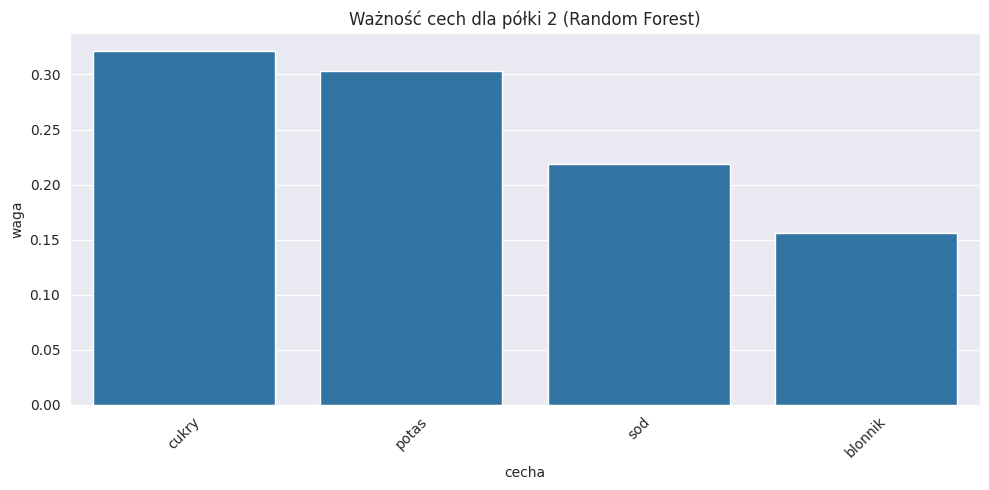

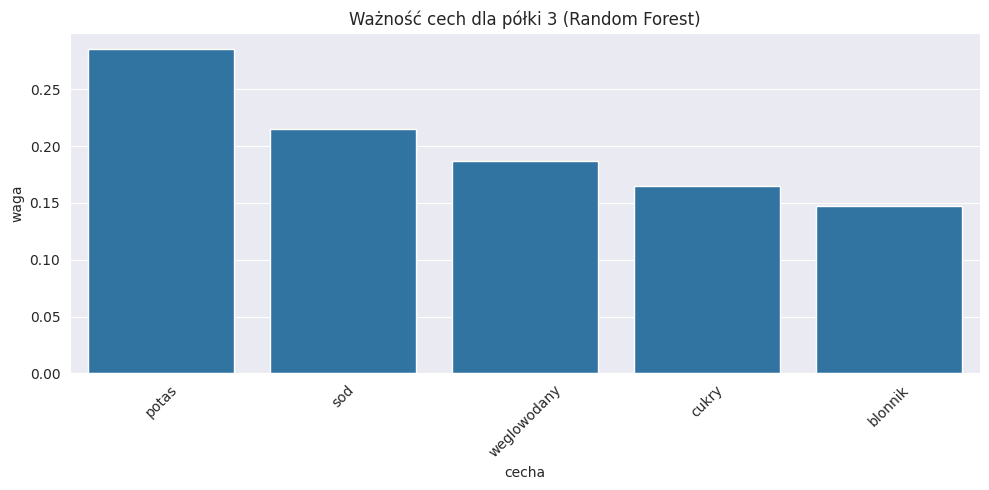

In [145]:
def plot_feature_importance():
    for shelf_num, shelf in enumerate(['polka_1', 'polka_2', 'polka_3'], 1):
        y_shelf = (df[shelf] == 1).astype(int)
        
        # # Random Forest feature importance
        # rf = RandomForestClassifier(n_estimators=200, random_state=42)
        # rf.fit(X_full_scaled, y_shelf)
        
        # Wybór cech
        selector = SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=42))
        selector.fit(X_full_scaled, y_shelf)
        selected_mask = selector.get_support()
        
        # Tylko wybrane cechy
        selected_features = [feat for feat, selected in zip(features, selected_mask) if selected]
        
        # Random Forest tylko na wybranych cechach
        rf = RandomForestClassifier(n_estimators=200, random_state=42)
        rf.fit(X_full_scaled[:, selected_mask], y_shelf)
        
        # Wizualizacja
        plt.figure(figsize=(10, 5))
        feature_importance = pd.DataFrame({
            'cecha': selected_features,
            'waga': rf.feature_importances_
        })
        feature_importance = feature_importance.sort_values('waga', ascending=False)
        sns.barplot(data=feature_importance, x='cecha', y='waga')
        plt.title(f'Ważność cech dla półki {shelf_num} (Random Forest)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
print("\n=== Ważność cech dla każdej półki ===")
plot_feature_importance()

### Wykres rozmieszczenia płatków z prawdopodobieństwem


=== Mapa decyzyjna dla klasyfikacji środkowej półki ===


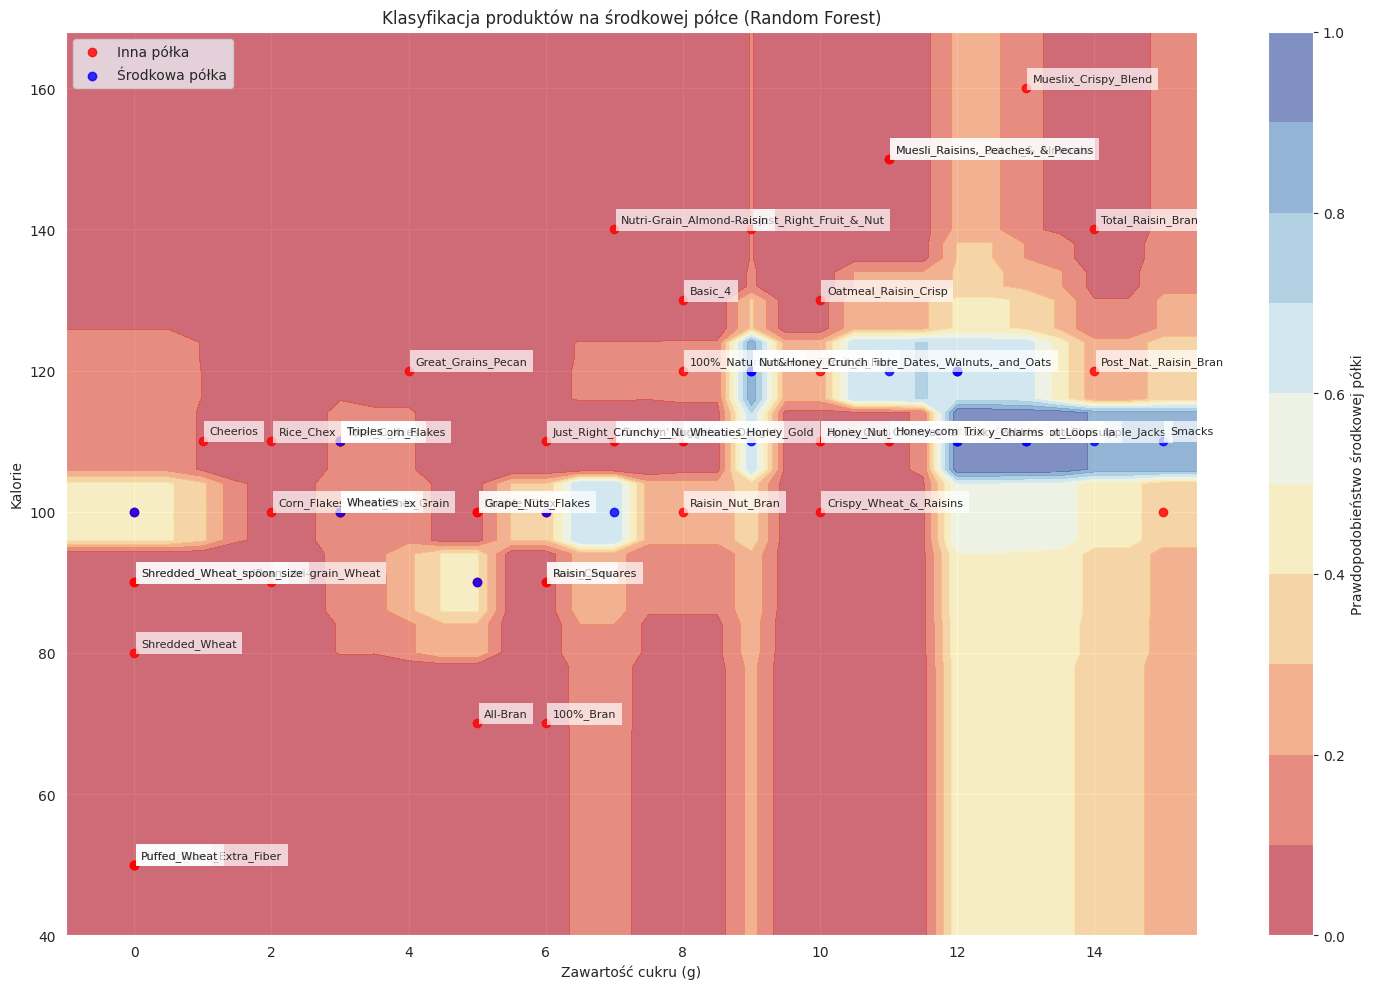

In [146]:
def plot_decision_boundary():
    plt.figure(figsize=(15, 10))
    
    # Granice decyzyjne dla Random Forest
    x_min, x_max = X_simple['cukry'].min() - 1, X_simple['cukry'].max() + 1 # -1 i +1 to margines
    y_min, y_max = X_simple['kalorie'].min() - 10, X_simple['kalorie'].max() + 10 # -10 i +10 to margines
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), # 0.5 to krok
                         np.arange(y_min, y_max, 2)) # 2 to krok
    
    # Standaryzacja danych
    grid_points = np.c_[xx.ravel(), yy.ravel()] # Ravel - splaszczanie tablicy\
    grid_points_scaled = scaler_simple.transform(grid_points) # Standaryzacja danych
    
    # Predykcja dla każdego punktu
    rf = classifiers_simple['Random Forest']
    Z = rf.predict_proba(grid_points_scaled)[:, 1]
    Z = Z.reshape(xx.shape)
    
    # Mapa decyzyjna
    plt.contourf(xx, yy, Z, levels=np.linspace(0, 1, 11), alpha=0.6, cmap='RdYlBu')
    plt.colorbar(label='Prawdopodobieństwo środkowej półki')
    
    # Punkty danych
    plt.scatter(X_simple['cukry'][y_middle == 0], X_simple['kalorie'][y_middle == 0],
                c='red', label='Inna półka', alpha=0.8)
    plt.scatter(X_simple['cukry'][y_middle == 1], X_simple['kalorie'][y_middle == 1], 
                c='blue', label='Środkowa półka', alpha=0.8)
    
    # Etykiety produktów
    for i, row in df.iterrows():
        point_scaled = scaler_simple.transform([[row['cukry'], row['kalorie']]])
        prob = rf.predict_proba(point_scaled)[0][1]
        if prob > 0.7 or prob < 0.3:
            plt.annotate(row['nazwa'],
                         (row['cukry'], row['kalorie']),
                         xytext=(5, 5),
                         textcoords='offset points',
                         fontsize=8,
                         bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    plt.xlabel('Zawartość cukru (g)')
    plt.ylabel('Kalorie')
    plt.title('Klasyfikacja produktów na środkowej półce (Random Forest)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n=== Mapa decyzyjna dla klasyfikacji środkowej półki ===")
plot_decision_boundary()